> **Bank "churn" dataset**
<br>` 'Exited' is our classification target `
<br>` 1 - went elsewhere (nonzero is True) `
<br>` 0 - remains as a customer `

**Import the main libraries**

In [1]:
import pandas as pd
import numpy as np

from time import time

_import the local library_

In [2]:
# add parent folder path where lib folder is
import sys
if ".." not in sys.path:import sys; sys.path.insert(0, '..') 

In [3]:
from mylib import show_labels_dist, show_metrics, bias_var_metrics

**Import the Dataset**

In [4]:
## file path: windows style
data = pd.read_csv('churn_modelling.csv')

## file path: unix style
#data = pd.read_csv('../datasets/churn_modelling.csv')

# shape method gives the dimensions of the dataset
print('Dataset dimensions: {} rows, {} columns'.format(data.shape[0], data.shape[1]))

Dataset dimensions: 10000 rows, 14 columns


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


In [6]:
data.head(13)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0
5,6,15574012,Chu,645,Spain,Male,44,8,113755.78,2,1,0,149756.71,1
6,7,15592531,Bartlett,822,France,Male,50,7,0.00,2,1,1,10062.80,0
7,8,15656148,Obinna,376,Germany,Female,29,4,115046.74,4,1,0,119346.88,1
8,9,15792365,He,501,France,Male,44,4,142051.07,2,0,1,74940.50,0
9,10,15592389,H?,684,France,Male,27,2,134603.88,1,1,1,71725.73,0


***
**Data Preparation and EDA** (unique to this dataset)
* _Check for missing values_
* _Quick visual check of unique values_
* _Split the classification feature out of the dataset_
* _Check column names of categorical attributes ( for get_dummies() )_
* _Check column names of numeric attributes ( for Scaling )_

**Check for missing values**

In [7]:
cnt=0
print('Missing Values - ')
for col in data.columns:
    nnul = pd.notnull(data[col]) 
    if (len(nnul)!=len(data)):
        cnt=cnt+1
        print('\t',col,':',(len(data)-len(nnul)),'null values')
print('Total',cnt,'features with null values')

# address missing values here

Missing Values - 
Total 0 features with null values


**Quick visual check of unique values, deal with unique identifiers**

In [8]:
# Identify columns with only one value 
# or with number of unique values == number of rows
n_eq_one = []
n_eq_all = []

print('Unique value count (',data.shape[0],'Rows in the dataset )')
for col in data.columns:
    lc = len(data[col].unique())
    print(col, ' ::> ', lc)
    if lc == 1:
        n_eq_one.append(data[col].name)
    if lc == data.shape[0]:
        n_eq_all.append(data[col].name)

Unique value count ( 10000 Rows in the dataset )
RowNumber  ::>  10000
CustomerId  ::>  10000
Surname  ::>  2932
CreditScore  ::>  460
Geography  ::>  3
Gender  ::>  2
Age  ::>  70
Tenure  ::>  11
Balance  ::>  6382
NumOfProducts  ::>  4
HasCrCard  ::>  2
IsActiveMember  ::>  2
EstimatedSalary  ::>  9999
Exited  ::>  2


In [9]:
# Drop columns with only one value
if len(n_eq_one) > 0:
    print('Dropping single-valued features')
    print(n_eq_one)
    data.drop(n_eq_one, axis=1, inplace=True)

# Drop or bin columns with number of unique values == number of rows
if len(n_eq_all) > 0:
    print('Dropping unique identifiers')
    print(n_eq_all)
    data.drop(n_eq_all, axis=1, inplace=True)

# continue with featue selection / feature engineering

Dropping unique identifiers
['RowNumber', 'CustomerId']


In [10]:
# Remove one more column that will not help predict the outcome
data.drop(['Surname'], axis=1, inplace=True)
data.head(2)

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0


* let's "bin" Age, Balance, and EstimatedSalary<br> 
_we could try to guess at the categories,_<br> 
_but let's use a function from our local library_

In [11]:
from mylib import autobin

In [12]:
# before we start, let's shorten one feature name))
data.rename(columns={'EstimatedSalary': 'Salary'}, inplace = True)

In [13]:
for feat in ['Age', 'Balance', 'Salary']:
    print(feat, '- minValue: ', data[feat].min(), 
          '  maxValue: ', data[feat].max())

Age - minValue:  18   maxValue:  92
Balance - minValue:  0.0   maxValue:  250898.09
Salary - minValue:  11.58   maxValue:  199992.48


In [14]:
for feat in ['Age', 'Balance', 'Salary']:
    cuts, cats = autobin(data, feat)

    newcol = feat + 'Range'
    data[newcol] = pd.cut(data[feat], bins=cuts, labels=cats) 
    
    print('Unique value count:',feat,len(data[feat].unique()),
          '  ',newcol,len(data[newcol].unique())-1,'\n')

Found 8 Bins
Unique value count: Age 70    AgeRange 8 

Found 15 Bins
Adjusted to 8 Bins
Adding a Zero bin
Unique value count: Balance 6382    BalanceRange 9 

Found 15 Bins
Adjusted to 8 Bins
Unique value count: Salary 9999    SalaryRange 8 



In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   CreditScore     10000 non-null  int64   
 1   Geography       10000 non-null  object  
 2   Gender          10000 non-null  object  
 3   Age             10000 non-null  int64   
 4   Tenure          10000 non-null  int64   
 5   Balance         10000 non-null  float64 
 6   NumOfProducts   10000 non-null  int64   
 7   HasCrCard       10000 non-null  int64   
 8   IsActiveMember  10000 non-null  int64   
 9   Salary          10000 non-null  float64 
 10  Exited          10000 non-null  int64   
 11  AgeRange        9978 non-null   category
 12  BalanceRange    9999 non-null   category
 13  SalaryRange     9999 non-null   category
dtypes: category(3), float64(2), int64(7), object(2)
memory usage: 889.9+ KB


In [16]:
# let's drop the detail and keep the categories
#   Using inPlace makes permanent changes to the dataframe in memory 
#   otherwise drop() will not affect the dataset we are working on
for feat in ['Age', 'Balance', 'Salary']:
    data.drop([feat], axis=1, inplace=True)

In [17]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   CreditScore     10000 non-null  int64   
 1   Geography       10000 non-null  object  
 2   Gender          10000 non-null  object  
 3   Tenure          10000 non-null  int64   
 4   NumOfProducts   10000 non-null  int64   
 5   HasCrCard       10000 non-null  int64   
 6   IsActiveMember  10000 non-null  int64   
 7   Exited          10000 non-null  int64   
 8   AgeRange        9978 non-null   category
 9   BalanceRange    9999 non-null   category
 10  SalaryRange     9999 non-null   category
dtypes: category(3), int64(6), object(2)
memory usage: 655.5+ KB


**<br>Classification target feature**
<br>"the Right Answers", or more formally "the desired outcome"
<br>Must be in a separate dataset for classification ,,,

In [18]:
## 'Exited' is our classification target 
## 1 (nonzero is True) - went elsewhere, zero - remains as a customer
print(data['Exited'].value_counts())

Exited
0    7963
1    2037
Name: count, dtype: int64


In [19]:
## Text labels look better in the confusion matrix

## a 'lambda' function is always simple, used only once
#data.Exited = data.Exited.apply(lambda x: 'Gone' if x==1 else 'Here')

## an alternative to a 'lambda' that has the same effect
data['Exited'] = ['Gone' if x==1 else 'Here' for x in data['Exited']]

## Let's change the name to 'Status' too - 'rename' is like 'drop'
## setting the parameter 'inplace' to True changes the original DataFrame 
## if not set, a new DataFrame is returned
data.rename(columns={'Exited': 'Status'}, inplace = True)

data['Status'].value_counts()

Status
Here    7963
Gone    2037
Name: count, dtype: int64

In [20]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   CreditScore     10000 non-null  int64   
 1   Geography       10000 non-null  object  
 2   Gender          10000 non-null  object  
 3   Tenure          10000 non-null  int64   
 4   NumOfProducts   10000 non-null  int64   
 5   HasCrCard       10000 non-null  int64   
 6   IsActiveMember  10000 non-null  int64   
 7   Status          10000 non-null  object  
 8   AgeRange        9978 non-null   category
 9   BalanceRange    9999 non-null   category
 10  SalaryRange     9999 non-null   category
dtypes: category(3), int64(5), object(3)
memory usage: 655.5+ KB


* Split the classification feature out of the dataset 

In [21]:
## Feature being predicted ("the Right Answer")
labels_col = 'Status'
y = data[labels_col]

## Features used for prediction 
# pandas has a lot of rules about returning a 'view' vs. a copy from slice
# so we force it to create a new dataframe 
X = data.copy()
X.drop(labels_col, axis=1, inplace=True)

**<br>Check column names of categorical attributes**
<br>Features with text values (categorical attributes) need to be normalised
<br>by changing them to numeric types that the algorithms find easier to work with

In [22]:
categori = X.select_dtypes(include=['object','category']).columns
print(categori.to_list())

['Geography', 'Gender', 'AgeRange', 'BalanceRange', 'SalaryRange']


In [23]:
# check the distribution of the feature values 
for col in categori:
    print('Distribution of categories in', col)
    print(X[col].value_counts())
    print()

Distribution of categories in Geography
Geography
France     5014
Germany    2509
Spain      2477
Name: count, dtype: int64

Distribution of categories in Gender
Gender
Male      5457
Female    4543
Name: count, dtype: int64

Distribution of categories in AgeRange
AgeRange
27-35       3589
36-44       3280
45-54       1311
18-26        998
55-63        518
64-72        210
73-81         65
Above 81       7
Name: count, dtype: int64

Distribution of categories in BalanceRange
BalanceRange
(Zero)           3617
100359-133811    2785
133812-167264    1605
66906-100358     1351
167265-200717     353
33453-66905       244
200718-234170      30
Under 33453        13
Above 234170        1
Name: count, dtype: int64

Distribution of categories in SalaryRange
SalaryRange
53339-80002      1373
80003-106667     1369
106668-133331    1340
159996-186659    1332
26675-53338      1311
133332-159995    1309
11-26674         1304
Above 186659      661
Name: count, dtype: int64



* 'one hot' encoding transforms a single column of text values into 
multiple columns of discrete values: 
it creates a new column for each unique value and puts
(one) in the column for which it is true and (zero) in the others

In [24]:
# the automatic way adds the original feature name
X = pd.get_dummies(X)

In [25]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 35 columns):
 #   Column                      Non-Null Count  Dtype
---  ------                      --------------  -----
 0   CreditScore                 10000 non-null  int64
 1   Tenure                      10000 non-null  int64
 2   NumOfProducts               10000 non-null  int64
 3   HasCrCard                   10000 non-null  int64
 4   IsActiveMember              10000 non-null  int64
 5   Geography_France            10000 non-null  bool 
 6   Geography_Germany           10000 non-null  bool 
 7   Geography_Spain             10000 non-null  bool 
 8   Gender_Female               10000 non-null  bool 
 9   Gender_Male                 10000 non-null  bool 
 10  AgeRange_18-26              10000 non-null  bool 
 11  AgeRange_27-35              10000 non-null  bool 
 12  AgeRange_36-44              10000 non-null  bool 
 13  AgeRange_45-54              10000 non-null  bool 
 14  AgeRang

**<br>Check column names of numeric attributes**
<br>Features with numeric values need to be normalised by changing the values to
small numbers in a specific range (scaling). _Note that scaling comes_ after _the test//train split!_

In [26]:
numeri = X.select_dtypes(include=['float64','int64']).columns
print(numeri.to_list())

['CreditScore', 'Tenure', 'NumOfProducts', 'HasCrCard', 'IsActiveMember']


***

**<br>Create Test // Train Datasets**
> Split X and y datasets into Train and Test subsets,<br>keeping relative proportions of each class (stratify)

In [27]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test =train_test_split(X, y,
                                                   test_size=0.2,
                                                   random_state=50,
                                                   stratify=y)
# train_test_split does random selection, 
#      so we should reset the dataframe indexes
X_train.reset_index(inplace=True, drop=True)
X_test.reset_index(inplace=True, drop=True)
y_train.reset_index(inplace=True, drop=True)
y_test.reset_index(inplace=True, drop=True)

***
Next are standard steps for all datasets: _scaling, classifiers, results_

**Scaling** comes _after_ test // train split

In [28]:
# data before normalization
X_test.head()

,CreditScore,Tenure,NumOfProducts,HasCrCard,IsActiveMember,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male,...,BalanceRange_200718-234170,BalanceRange_Above 234170,SalaryRange_11-26674,SalaryRange_26675-53338,SalaryRange_53339-80002,SalaryRange_80003-106667,SalaryRange_106668-133331,SalaryRange_133332-159995,SalaryRange_159996-186659,SalaryRange_Above 186659
0,748,8,2,1,0,True,False,False,True,False,...,False,False,False,False,True,False,False,False,False,False
1,601,3,2,1,0,False,False,True,True,False,...,False,False,False,False,True,False,False,False,False,False
2,665,2,1,0,0,True,False,False,False,True,...,False,False,False,False,True,False,False,False,False,False
3,768,3,1,0,0,False,False,True,True,False,...,False,False,False,False,False,False,False,False,True,False
4,487,4,1,1,1,True,False,False,False,True,...,False,False,True,False,False,False,False,False,False,False


In [29]:
# scaling the Numeric columns 
# StandardScaler range: -1 to 1, MinMaxScaler range: zero to 1

# from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

# sklearn docs say 
#   "Don't cheat - fit only on training data, then transform both"
#   fit() expects 2D array: reshape(-1, 1) for single col or (1, -1) single row

for i in numeri:
    arr = np.array(X_train[i])
    scale = MinMaxScaler().fit(arr.reshape(-1, 1))
    X_train[i] = scale.transform(arr.reshape(len(arr),1))

    arr = np.array(X_test[i])
    X_test[i] = scale.transform(arr.reshape(len(arr),1))
    

In [30]:
# data after normalization
X_test.head()

,CreditScore,Tenure,NumOfProducts,HasCrCard,IsActiveMember,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male,...,BalanceRange_200718-234170,BalanceRange_Above 234170,SalaryRange_11-26674,SalaryRange_26675-53338,SalaryRange_53339-80002,SalaryRange_80003-106667,SalaryRange_106668-133331,SalaryRange_133332-159995,SalaryRange_159996-186659,SalaryRange_Above 186659
0,0.796,0.8,0.333333,1.0,0.0,True,False,False,True,False,...,False,False,False,False,True,False,False,False,False,False
1,0.502,0.3,0.333333,1.0,0.0,False,False,True,True,False,...,False,False,False,False,True,False,False,False,False,False
2,0.630,0.2,0.000000,0.0,0.0,True,False,False,False,True,...,False,False,False,False,True,False,False,False,False,False
3,0.836,0.3,0.000000,0.0,0.0,False,False,True,True,False,...,False,False,False,False,False,False,False,False,True,False
4,0.274,0.4,0.000000,1.0,1.0,True,False,False,False,True,...,False,False,True,False,False,False,False,False,False,False


**<br>Classifier Selection**

In [31]:
# prepare list
models = []

##  --  Linear  --  ## 
#from sklearn.linear_model import LogisticRegression 
#models.append (("LogReg",LogisticRegression())) 
#from sklearn.linear_model import SGDClassifier 
#models.append (("StocGradDes",SGDClassifier())) 
#from sklearn.discriminant_analysis import LinearDiscriminantAnalysis 
#models.append(("LinearDA", LinearDiscriminantAnalysis())) 
#from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis 
#models.append(("QuadraticDA", QuadraticDiscriminantAnalysis())) 

##  --  Support Vector  --  ## 
#from sklearn.svm import SVC 
#models.append(("SupportVectorClf", SVC())) 
#from sklearn.svm import LinearSVC 
#models.append(("LinearSVC", LinearSVC())) 
#from sklearn.linear_model import RidgeClassifier
#models.append (("RidgeClf",RidgeClassifier())) 

##  --  Non-linear  --  ## 
#from sklearn.tree import DecisionTreeClassifier 
#models.append (("DecisionTree",DecisionTreeClassifier())) 
#from sklearn.naive_bayes import GaussianNB 
#models.append (("GaussianNB",GaussianNB())) 
#from sklearn.neighbors import KNeighborsClassifier 
#models.append(("K-NNeighbors", KNeighborsClassifier())) 

##  --  Ensemble: bagging  --  ## 
from sklearn.ensemble import RandomForestClassifier 
models.append(("RandomForest", RandomForestClassifier())) 
##  --  Ensemble: boosting  --  ## 
#from sklearn.ensemble import AdaBoostClassifier 
#models.append(("AdaBoost", AdaBoostClassifier())) 
#from sklearn.ensemble import GradientBoostingClassifier 
#models.append(("GradientBoost", GradientBoostingClassifier())) 

##  --  NeuralNet (simplest)  --  ## 
#from sklearn.linear_model import Perceptron 
#models.append (("SingleLayerPtron",Perceptron())) 
#from sklearn.neural_network import MLPClassifier 
#models.append(("MultiLayerPtron", MLPClassifier()))

print(models)

[('RandomForest', RandomForestClassifier())]


**<br>Target Label Distributions** (standard block)

In [32]:
# from our local library
show_labels_dist(X_train,X_test,y_train,y_test)

features_train: 8000 rows, 35 columns
features_test:  2000 rows, 35 columns

labels_train: 8000 rows, 1 column
labels_test:  2000 rows, 1 column

Frequency and Distribution of labels
        Status  %_train  Status  %_test
Status                                 
Here      6370    79.62    1593   79.65
Gone      1630    20.38     407   20.35


**<br>Fit and Predict** (standard block)

In [33]:
# evaluate each model in turn
results = []

print('macro average: unweighted mean per label')
print('weighted average: support-weighted mean per label')
print('MCC: correlation between prediction and ground truth')
print('     (+1 perfect, 0 random prediction, -1 inverse)\n')

for name, clf in models:
    trs = time()
    print('Confusion Matrix:', name)
    
    clf.fit(X_train, y_train)
    ygx = clf.predict(X_test)
    results.append((name, ygx))
    
    tre = time() - trs
    print ("Run Time {} seconds".format(round(tre,2)) + '\n')
    
# Easy way to ensure that the confusion matrix rows and columns
#   are labeled exactly as the classifier has coded the classes
#   [[note the _ at the end of clf.classes_ ]]

    show_metrics(y_test, ygx, clf.classes_)   # from our local library
    print('\nParameters: ', clf.get_params(), '\n\n')

macro average: unweighted mean per label
weighted average: support-weighted mean per label
MCC: correlation between prediction and ground truth
     (+1 perfect, 0 random prediction, -1 inverse)

Confusion Matrix: RandomForest
Run Time 0.42 seconds

            pred:Gone  pred:Here
train:Gone        177        230
train:Here         80       1513

~~~~
   macro avg :  FPR = 0.308   FNR = 0.308
weighted avg :  FPR = 0.155   FNR = 0.155

~~~~
              precision    recall  f1-score   support

        Gone      0.689     0.435     0.533       407
        Here      0.868     0.950     0.907      1593

    accuracy                          0.845      2000
   macro avg      0.778     0.692     0.720      2000
weighted avg      0.832     0.845     0.831      2000

~~~~
MCC: Overall :  0.463

Parameters:  {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decr

**Bias - Variance Decomposition** (standard block)

In [34]:
# from our local library
# reduce (cross-validation) folds for faster results
folds = 20
for name, clf in models:
    print('Bias // Variance Decomposition:', name)
    bias_var_metrics(X_train,X_test,y_train,y_test,clf,folds)

Bias // Variance Decomposition: RandomForest
   Average bias: 0.151
   Average variance: 0.042
   Average expected loss: 0.154  "Goodness": 0.846



***

***

***
**<br>Feature Selection using Correlations**<br>
> Same rule as scaling applies here:<br>
> "Don't cheat - get the filter only on the training data<br>
> then apply the filter to both the training and test data"

In [35]:
# save our original datasets before we test the reduced ones
XtrainOriginal = X_train
XtestOriginal = X_test

**<br>Pearson correlation, Mutual Information, Symmetric Uncertainty**
<br>The Pearson correlation coefficient (r) is the most common way of measuring a linear correlation. It is a number between –1 and 1 that measures the strength and direction of the relationship between two variables.
<br><br>
Mutual Information (MI) is a measure of the information that X and Y share - in effect, how much knowing one of these variables reduces uncertainty about the other (information gain). In other words, MI tells us how useful the feature X is at predicting the random variable Y on a scale of zero to one, with higher numbers indicating better predictors.
<br><br>
MI has a lot of advocates because it can capture may types of dependencies. There is a nice illustration of this in the sklearn documentation, comparing MI to the (anova) F-test, which captures only linear dependency like the pearson r metric:<br>
https://scikit-learn.org/stable/auto_examples/feature_selection/plot_f_test_vs_mi.html
<br><br>
Symmetric uncertainty (SU) compensates for mutual information's bias towards features having large number of different values and normalizes within range [0,1].
<br><br>
_IMPORTANT: Pearson Correlation and MI/SU are complementary, in the sense that high values for one do not mean high vales for the other, so we should check both when using them for feature selection_

In [36]:
# from our local library
from mylib import filter_fcy, rpt_ycor, get_filter 

# for graphs
import matplotlib.pyplot as plt
import seaborn as sns

# Requires numeric values for the target feature
from sklearn.preprocessing import LabelEncoder
## Feature being predicted ("the Right Answer")
ynum = LabelEncoder().fit_transform(y_train)

In [37]:
# generate lists of features to keep and to drop
# requires numeric labels
droplist, keeplist = filter_fcy(X_train, ynum)
print('Floor Filter:',len(keeplist),'features to keep,',len(droplist),'to drop')

Floor Filter: 16 features to keep, 19 to drop


In [38]:
# take a look ...
rpt_ycor(droplist)

--Feature--                       PCy          SUy          MIy   
Tenure                             0.014       0.0006       0.0009
HasCrCard                          0.007          0.0          0.0
AgeRange_36-44                   -0.0039          0.0          0.0
AgeRange_64-72                     0.007       0.0001          0.0
AgeRange_Above 81                 0.0045          0.0          0.0
BalanceRange_Under 33453          -0.026       0.0011       0.0003
BalanceRange_33453-66905         -0.0185       0.0005       0.0002
BalanceRange_66906-100358         0.0001          0.0          0.0
BalanceRange_133812-167264       -0.0242       0.0006       0.0003
BalanceRange_167265-200717       -0.0174       0.0004       0.0001
BalanceRange_Above 234170        -0.0221       0.0008       0.0002
SalaryRange_11-26674             -0.0022          0.0          0.0
SalaryRange_26675-53338           0.0115       0.0002       0.0001
SalaryRange_53339-80002           0.0093       0.0001         

In [39]:
rpt_ycor(keeplist)

--Feature--                       PCy          SUy          MIy   
CreditScore                       0.0325       0.0103       0.0329
NumOfProducts                     0.0472       0.1096       0.0733
IsActiveMember                    0.1636       0.0225       0.0135
Geography_France                  0.1078       0.0098       0.0058
Geography_Germany                 -0.173        0.026       0.0139
Geography_Spain                   0.0496       0.0024       0.0013
Gender_Female                    -0.1092       0.0099       0.0059
Gender_Male                       0.1092       0.0099       0.0059
AgeRange_18-26                    0.1096       0.0176       0.0074
AgeRange_27-35                    0.2081       0.0413       0.0239
AgeRange_45-54                   -0.2948       0.0812        0.036
AgeRange_55-63                   -0.1704       0.0332       0.0118
AgeRange_73-81                    0.0413       0.0056       0.0015
BalanceRange_(Zero)               0.1321       0.0158       0.

In [40]:
# make a dataframe from the Keep List
ffdf = pd.DataFrame(keeplist, columns=['Feature','PCy','SUy','MIy'])
#ffdf.head()

In [41]:
# --  --
# Get this many highest Symmetric Uncertainty
sunf = 6        # (number of features to select)
# Get this many highest & lowest Pearson Correlations from the rest
pcnf = 2        # (number of features to select)
# --  --

corhi = ffdf.sort_values('SUy',ascending=False).head(sunf)
hicor = list(corhi['Feature'].values)
# these are selected, so drop them out
tmp_df = ffdf[~ffdf.Feature.isin(hicor)]

pcorhi = tmp_df.sort_values('PCy',ascending=False).head(pcnf)
hicor.extend(n for n in list(pcorhi['Feature'].values))
pcorlo = tmp_df.sort_values('PCy',ascending=False).tail(pcnf)
hicor.extend(n for n in list(pcorlo['Feature'].values))

# create a new dataframe with just those columns ...
hcXtrain = ffdf[ffdf.Feature.isin(hicor)]

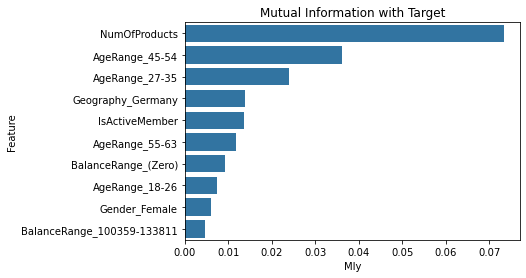

In [42]:
# ... for visualisation
#cc = 'PCy'
#cl = 'Pearson Correlation'
#cc = 'SUy'
#cl = 'Symmetric Uncertainty'
cc = 'MIy'
cl = 'Mutual Information'
sns.barplot(x = cc, y = "Feature", 
            data = hcXtrain.sort_values(cc, ascending=False)).set(
    title = cl + ' with Target')
plt.show()

**<br>Evaluate: Full Keep List**

In [43]:
# apply the filter to create new train and test dataframes
kXtrain = X_train.filter(get_filter(keeplist))
kXtest = X_test.filter(get_filter(keeplist))

X_train = kXtrain
X_test = kXtest

# Create a list of the feature names
cols = list(X_train.columns)

In [44]:
# Create a list of the feature names
cols = list(X_train.columns)
print(cols)

['CreditScore', 'NumOfProducts', 'IsActiveMember', 'Geography_France', 'Geography_Germany', 'Geography_Spain', 'Gender_Female', 'Gender_Male', 'AgeRange_18-26', 'AgeRange_27-35', 'AgeRange_45-54', 'AgeRange_55-63', 'AgeRange_73-81', 'BalanceRange_(Zero)', 'BalanceRange_100359-133811', 'BalanceRange_200718-234170']


**<br>Fit and Predict** (standard block)

In [45]:
# evaluate each model in turn
results = []

print('macro average: unweighted mean per label')
print('weighted average: support-weighted mean per label')
print('MCC: correlation between prediction and ground truth')
print('     (+1 perfect, 0 random prediction, -1 inverse)\n')

for name, clf in models:
    trs = time()
    print('Confusion Matrix:', name)
    
    clf.fit(X_train, y_train)
    ygx = clf.predict(X_test)
    results.append((name, ygx))
    
    tre = time() - trs
    print ("Run Time {} seconds".format(round(tre,2)) + '\n')
    
# Easy way to ensure that the confusion matrix rows and columns
#   are labeled exactly as the classifier has coded the classes
#   [[note the _ at the end of clf.classes_ ]]

    show_metrics(y_test, ygx, clf.classes_)   # from our local library
    print('\nParameters: ', clf.get_params(), '\n\n')

macro average: unweighted mean per label
weighted average: support-weighted mean per label
MCC: correlation between prediction and ground truth
     (+1 perfect, 0 random prediction, -1 inverse)

Confusion Matrix: RandomForest
Run Time 0.4 seconds

            pred:Gone  pred:Here
train:Gone        204        203
train:Here        195       1398

~~~~
   macro avg :  FPR = 0.311   FNR = 0.311
weighted avg :  FPR = 0.199   FNR = 0.199

~~~~
              precision    recall  f1-score   support

        Gone      0.511     0.501     0.506       407
        Here      0.873     0.878     0.875      1593

    accuracy                          0.801      2000
   macro avg      0.692     0.689     0.691      2000
weighted avg      0.800     0.801     0.800      2000

~~~~
MCC: Overall :  0.382

Parameters:  {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decre

**Bias - Variance Decomposition** (standard block)

In [46]:
# from our local library
# reduce (cross-validation) folds for faster results
folds = 20
for name, clf in models:
    print('Bias // Variance Decomposition:', name)
    bias_var_metrics(X_train,X_test,y_train,y_test,clf,folds)

Bias // Variance Decomposition: RandomForest
   Average bias: 0.201
   Average variance: 0.076
   Average expected loss: 0.202  "Goodness": 0.798



**<br>Evaluate: High Correlation**

In [47]:
# apply the filter to create new train and test dataframes
hXtrain = X_train.filter(hicor)
hXtest = X_test.filter(hicor)

X_train = hXtrain
X_test = hXtest

# Create a list of the feature names
cols = list(X_train.columns)
print(cols)

['NumOfProducts', 'AgeRange_45-54', 'AgeRange_27-35', 'AgeRange_55-63', 'Geography_Germany', 'IsActiveMember', 'BalanceRange_(Zero)', 'AgeRange_18-26', 'BalanceRange_100359-133811', 'Gender_Female']


**<br>Fit and Predict**

In [48]:
# add standard blocks for performance metrics
# and blocks for appropriate visualisations

In [49]:
# evaluate each model in turn
results = []

print('macro average: unweighted mean per label')
print('weighted average: support-weighted mean per label')
print('MCC: correlation between prediction and ground truth')
print('     (+1 perfect, 0 random prediction, -1 inverse)\n')

for name, clf in models:
    trs = time()
    print('Confusion Matrix:', name)
    
    clf.fit(X_train, y_train)
    ygx = clf.predict(X_test)
    results.append((name, ygx))
    
    tre = time() - trs
    print ("Run Time {} seconds".format(round(tre,2)) + '\n')
    
# Easy way to ensure that the confusion matrix rows and columns
#   are labeled exactly as the classifier has coded the classes
#   [[note the _ at the end of clf.classes_ ]]

    show_metrics(y_test, ygx, clf.classes_)   # from our local library
    print('\nParameters: ', clf.get_params(), '\n\n')

macro average: unweighted mean per label
weighted average: support-weighted mean per label
MCC: correlation between prediction and ground truth
     (+1 perfect, 0 random prediction, -1 inverse)

Confusion Matrix: RandomForest
Run Time 0.2 seconds

            pred:Gone  pred:Here
train:Gone        197        210
train:Here         73       1520

~~~~
   macro avg :  FPR = 0.281   FNR = 0.281
weighted avg :  FPR = 0.141   FNR = 0.141

~~~~
              precision    recall  f1-score   support

        Gone      0.730     0.484     0.582       407
        Here      0.879     0.954     0.915      1593

    accuracy                          0.859      2000
   macro avg      0.804     0.719     0.748      2000
weighted avg      0.848     0.859     0.847      2000

~~~~
MCC: Overall :  0.516

Parameters:  {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decre

In [50]:
# from our local library
# reduce (cross-validation) folds for faster results
folds = 20
for name, clf in models:
    print('Bias // Variance Decomposition:', name)
    bias_var_metrics(X_train,X_test,y_train,y_test,clf,folds)

Bias // Variance Decomposition: RandomForest
   Average bias: 0.143
   Average variance: 0.026
   Average expected loss: 0.147  "Goodness": 0.853

